# U-Net3+ - attention gates

**Kaggle mean intersection over union metric** : 0.44

**Local test mean intersection over union metri** : 0.42

**Descrition** : Adding Residual Bottlenecking and attention gating mechanism to the U-Net3+ architecture

**Motivation** : making a to have a trainable fusion mechanism between features instead of concatenation

## Google Drive - Connecting to the project

In [ ]:
from google.colab import drive
import sys
drive.mount('/content/drive')
project_path = "/content/drive/MyDrive/Colab Notebooks/ANN/le acque del friuli - Homework 2"
%cd {project_path}
sys.path.append(project_path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/Colab Notebooks/ANN/le acque del friuli - Homework 2


## Imports

In [ ]:
# Set seed for reproducibility
seed = 19

# Import necessary libraries
import os

# Import necessary modules
import logging
import random
import numpy as np

# Set seeds for random number generators in NumPy and Python
np.random.seed(seed)
random.seed(seed)

# Import TensorFlow and Keras
import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl

# Set seed for TensorFlow
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

# Import other libraries
import os
import math
from PIL import Image
from keras import backend as K
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

import utils

# Configure plot display settings
sns.set(font_scale=1.4)
sns.set_style('white')
plt.rc('font', size=14)
%matplotlib inline

import sklearn.utils as skl_utils

In [ ]:
# Set batch size for training
BATCH_SIZE = 64

# Number of classes
NUM_CLASSES = 5

# Input Shape
INPUT_SHAPE = (64,128,1)

## Load Data

In [ ]:
# Load the dataset
data = np.load("dataset/cleaned_normalized_dataset.npz")

# Split the dataset in images and labels array
X = data['images']
y = data['labels']
X_test = data['test_set']

## Data Preprocessing

In [ ]:
# Normalize all the data into the 0-1 range
maxv = max(X.max(), X_test.max())
minv = min(X.min(), X_test.min())
X = (X - minv) / (maxv - minv)
X_test = (X_test - minv) / (maxv - minv)

In [ ]:
# Obtaining all the big_rocks_idxs
contains_value = np.any(y == 4, axis=(1, 2), keepdims=True)
big_rocks_idxs = np.where(np.squeeze(contains_value))[0]
print(big_rocks_idxs.shape)

(63,)


In [ ]:
# separate the dataset into one containing only Big Rocks and the other containing everything else
y = tfk.utils.to_categorical(y, num_classes=NUM_CLASSES)
X_big_rocks = X[big_rocks_idxs]
y_big_rocks = y[big_rocks_idxs]
X_rest = np.delete(X, big_rocks_idxs, axis=0)
y_rest = np.delete(y, big_rocks_idxs, axis=0)

In [ ]:
# Split the dataset into training and validation, ensuring the presence of BIG_ROCKS
X_train, X_val, y_train, y_val = train_test_split(X_rest, y_rest, test_size=0.2, random_state=seed)
X_train_rocks, X_val_rocks, y_train_rocks, y_val_rocks = train_test_split(X_big_rocks, y_big_rocks, test_size=0.2, random_state=seed)
print("---------------------\nX train shape without big rocks:", X_train.shape, y_train.shape)
print("X val shape without big rocks:",X_val.shape, y_val.shape)
print("X train shape with big rocks:",X_train_rocks.shape, y_train_rocks.shape)
print("X val shape with big rocks:",X_val_rocks.shape, y_val_rocks.shape)
X_train = np.concatenate((X_train, X_train_rocks), axis=0)
X_val = np.concatenate((X_val, X_val_rocks), axis=0)
y_train = np.concatenate((y_train, y_train_rocks), axis=0)
y_val = np.concatenate((y_val, y_val_rocks), axis=0)
print("\n--------------------\nX train shape:",X_train.shape,"\ny train shape:", y_train.shape)
print("X val shape:",X_val.shape,"\ny val shape:", y_val.shape)

---------------------
X train shape without big rocks: (1948, 64, 128) (1948, 64, 128, 5)
X val shape without big rocks: (487, 64, 128) (487, 64, 128, 5)
X train shape with big rocks: (50, 64, 128) (50, 64, 128, 5)
X val shape with big rocks: (13, 64, 128) (13, 64, 128, 5)

--------------------
X train shape: (1998, 64, 128) 
y train shape: (1998, 64, 128, 5)
X val shape: (500, 64, 128) 
y val shape: (500, 64, 128, 5)


In [ ]:
# A series of augmentation functions

def expand(image, label):
    return tf.expand_dims(image, axis=-1), tf.expand_dims(label, axis=-1)

def squeeze(image, label):
    return tf.squeeze(image, axis=-1), tf.squeeze(label, axis=-1)

# Flips the image and label horizontally.
def flip_lr(image, label):
    image, label = expand(image,label)
    image = tf.image.flip_left_right(image)
    label = tf.reverse(label, axis=[1])
    image, label = squeeze(image, label)
    return image, label

# Flips the image and label vertically.
def flip_ud(image, label):
    image, label = expand(image,label)
    image = tf.image.flip_up_down(image)
    label = tf.reverse(label, axis=[0])
    image, label = squeeze(image, label)
    return image, label

# Change contrast randomly
def random_contrast(image, label):
    image = tf.expand_dims(image, axis=-1)
    image = tf.image.random_contrast(image, lower=0.8, upper=1.2)
    image = tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)
    image = tf.squeeze(image, axis=-1)
    return image, label

In [ ]:
# Random pipeline augmentation
def preprocess(image, label):
    if tf.random.uniform(()) > 0.5:
        image, label = flip_lr(image, label)
    if tf.random.uniform(()) > 0.5:
        image, label = flip_ud(image, label)
    if tf.random.uniform(()) > 0.5:
        image, label = random_contrast(image, label)
    return image, label

In [ ]:
# Create a dataset with batch, augmentations and shuffle
def make_dataset(images,labels,batch_size, shuffle=True, augment=False, seed=None):
    # Convert images and labels to float32
    images = images.astype(np.float32)
    labels = labels.astype(np.float32)

    # prepar data for training with potentially multiple outputs
    dataset = tf.data.Dataset.from_tensor_slices((images,labels))

    if augment:
        # Expand the size and applying augmentation
        expansions = 3
        new_dataset = dataset.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
        for _ in range(expansions-1):
            processed = dataset.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
            new_dataset = new_dataset.concatenate(processed)
        dataset = new_dataset


    if shuffle:
        dataset = dataset.shuffle(buffer_size=batch_size * 2, seed=seed)

    # Batch the data
    dataset = dataset.batch(batch_size, drop_remainder=False)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)

    return dataset

In [ ]:
# Create the training dataset
train_dataset = make_dataset(
    X_train,
    y_train,
    batch_size=BATCH_SIZE,
    shuffle=True,
    augment=True,
    seed=seed
)

# Create the validation dataset
val_dataset = make_dataset(
    X_val,
    y_val,
    batch_size=BATCH_SIZE,
    shuffle=False,
    augment=False,
    seed=seed
)

Original training samples shape: (1998, 64, 128)
Number of training samples 6016


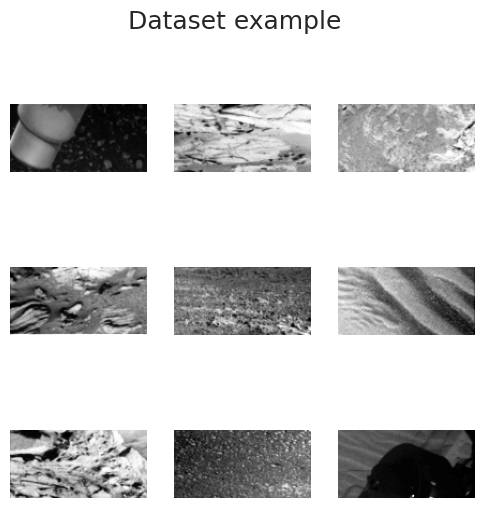

In [ ]:
print("Original training samples shape:", X_train.shape)
print("Number of training samples", len(list(train_dataset))*BATCH_SIZE)

# Print augmented images
def visualize_dataset(dataset, title):
    plt.figure(figsize=(6, 6))
    plt.suptitle(title, fontsize=18)
    for i, (images, labels) in enumerate(dataset.take(9)):
        plt.subplot(3, 3, i + 1)
        plt.imshow(images[0],cmap='gray')
        plt.axis("off")
    plt.show()

# Visualize the dataset
visualize_dataset(train_dataset, title="Dataset example")

## 🛠️ Train and Save the Model

In [ ]:
# Creates an encoder block for the model.
# Applies two convolutional layers with batch normalization and ReLU activation.

def encoder_block(input,  n_filters, kernel_size, strides):
    # Not using bias since we are using batch normalization after each layer
    # thus making the bias parameters redundant
    e = tfkl.Conv2D(filters=n_filters, kernel_size=kernel_size, strides=strides, padding='same', use_bias=False)(input)
    e = tfkl.BatchNormalization()(e)
    e = tfkl.Activation('relu')(e)
    e = tfkl.Conv2D(filters=n_filters, kernel_size=kernel_size, padding='same', use_bias=False)(e)
    e = tfkl.BatchNormalization()(e)
    e = tfkl.Activation('relu')(e)
    return e

In [ ]:
# creates a residual block
def res_bottleneck(input, n_filters, kernel_size, strides, name='', dropout=0.0):
    # Downscales the input
    down_input = tfkl.Conv2D(filters=n_filters, kernel_size=kernel_size, strides=strides, padding='same', use_bias=False)(input) # downscaling
    # Applies convolutional layers
    down_input = tfkl.BatchNormalization()(down_input)
    down_input = tfkl.Activation('relu')(down_input)
    e = tfkl.Conv2D(filters=n_filters, kernel_size=kernel_size, padding='same', use_bias=False)(down_input)
    e = tfkl.BatchNormalization()(e)
    e = tfkl.Activation('relu')(e)
    e = tfkl.Add()([e, down_input]) #skip connection to make this a residual block
    e = tfkl.BatchNormalization()(e)
    e = tfkl.Activation('relu')(e)
    # Applies dropout for regularization.
    e = tfkl.Dropout(rate=dropout)(e)
    return e

In [ ]:
def expand_as(tensor, rep):

    # Anonymous lambda function to expand the specified axis by a factor of argument, rep.
    # If tensor has shape (512,512,N), lambda will return a tensor of shape (512,512,N*rep), if specified axis=2

    output_shape = (tfk.backend.int_shape(tensor)[1],
                    tfk.backend.int_shape(tensor)[2],
                    tfk.backend.int_shape(tensor)[3]*rep)
    my_repeat = tfkl.Lambda(lambda x, repnum: tfk.backend.repeat_elements(x, repnum, axis=3), arguments={'repnum': rep},
                            output_shape=output_shape)(tensor)
    return my_repeat


def attnGatingBlock(x, g, inter_shape, downscale, dropout=0.0):
    print(f" Building attention block")
    print(f"    Using g=\n{g}")
    print(f"    Using this x=\n{x}\n")
    shape_x = tfk.backend.int_shape(x)
    shape_g = tfk.backend.int_shape(g)

    # Getting the gating signal to the same number of filters as the inter_shape
    phi_g = tfkl.Conv2D(filters=inter_shape, kernel_size=1, strides=1, padding='same')(g)

    # Getting the x signal to the same shape as the gating signal
    theta_x = tfkl.Conv2D(filters=inter_shape, kernel_size=3, strides=(shape_x[1] // shape_g[1], shape_x[2] // shape_g[2]), padding='same')(x)

    # Element-wise addition of the gating and x signals
    add_xg = tfkl.add([phi_g, theta_x])
    add_xg = tfkl.Activation('relu')(add_xg)

    # 1x1x1 convolution
    psi = tfkl.Conv2D(filters=1, kernel_size=1, padding='same')(add_xg)
    psi = tfkl.Activation('sigmoid')(psi)

    shape_sigmoid = tfk.backend.int_shape(psi)

    # Upsampling psi back to the original dimensions of x signal
    upsample_sigmoid_xg = tfkl.UpSampling2D(size=(shape_x[1] // shape_sigmoid[1], shape_x[2] // shape_sigmoid[2]))(psi)

    # Expanding the filter axis to the number of filters in the original x signal
    upsample_sigmoid_xg = expand_as(upsample_sigmoid_xg, shape_x[3])

    # Element-wise multiplication of attention coefficients back onto original x signal
    attn_coefficients = tfkl.multiply([upsample_sigmoid_xg, x])

    # Final 1x1x1 convolution to consolidate attention signal to original x dimensions
    output = tfkl.Conv2D(filters=shape_x[3], kernel_size=1, strides=1, padding='same')(attn_coefficients)
    output = tfkl.BatchNormalization()(output)

    # Downscaling to a feasible dimension for concatenation
    d = tfkl.Conv2D(filters=64, kernel_size=3, strides=downscale, padding='same', use_bias=False)(output)
    d = tfkl.BatchNormalization()(d)
    d = tfkl.Activation('relu')(d)
    print("    Attention block built. Output =",d)
    d = tfkl.Dropout(rate=dropout)(d)
    return d

In [ ]:
# Takes as input a series of layers to upscale, in order by the last one to the
# first one that has to be upscaled
def upscale_block(inputs, dropout=0.0):
    n_upscales = len(inputs) #number of input tensors
    upscale_layers = []

    # If we pass [(x,16,32,1), (y,32,64,1)] as input tensors we get [(x+y,64,128,1))]
    # since the first one is upscaled with 2**2 stride and the second one with 2**1
    for i, inp in enumerate(inputs):
        exponent = n_upscales - i
        u = tfkl.Conv2DTranspose(filters=64, kernel_size=3, strides=2**exponent, padding='same')(inp)

        # Each upscaling goes through further convolutions to reduce
        # superfluous information (as the paper says)
        for i in range(2):
            u = tfkl.Conv2D(filters=64, kernel_size=3, padding='same', use_bias=False)(u)
            u = tfkl.BatchNormalization()(u)
            u = tfkl.Activation('relu')(u)
            u = tfkl.Dropout(rate=dropout)(u)

        upscale_layers.append(u)
    return upscale_layers


In [ ]:
# Creates a decoder block for the model.
# Upscales features, concatenates with downscaled features,
#  and applies convolutions with batch normalization and ReLU activation.

def decoder_block(inputs_to_upscale, inputs_to_downscale, dropout=0.0):
    print("\n---------------------\nBuilding decoder block with:")
    print(" Inputs to upscale:",inputs_to_upscale)
    print(" Inputs to downscale:",inputs_to_downscale)
    upscaled_layers = upscale_block(inputs_to_upscale)
    print("     Upscaled layers:",upscaled_layers)

    g = inputs_to_upscale[-1]
    attention_outputs = []

    # Downscales using 2**i strides the layers coming from the encoder part
    # of the network
    for i, inp in enumerate(inputs_to_downscale):
        att = attnGatingBlock(inp, g, inter_shape=64,downscale=2**i)
        attention_outputs.append(att)


    print(attention_outputs)
    dec = tfkl.Concatenate()(upscaled_layers + attention_outputs)
    dec = tfkl.Conv2D(filters=256, kernel_size=3, padding='same', use_bias=False)(dec)
    dec = tfkl.BatchNormalization()(dec)
    dec = tfkl.Activation('relu')(dec)
    dec = tfkl.Dropout(rate=dropout)(dec)
    return dec


In [ ]:
# Definition of the model
def get_unet_model():
    inputs = tfkl.Input(shape=INPUT_SHAPE)

    # Downsampling path
    e1 = encoder_block(inputs, n_filters=32, kernel_size=3, strides=2)
    e2 = encoder_block(e1, n_filters=64, kernel_size=3, strides=2)
    e3 = encoder_block(e2, n_filters=128, kernel_size=3, strides=2)
    e4 = encoder_block(e3, n_filters=256, kernel_size=3, strides=2)

    # Bottleneck
    bottleneck = res_bottleneck(e4, n_filters=512, kernel_size=3, strides=2, name='res_bottleneck', dropout=0.2)

    # Upsampling path
    d1 = decoder_block(inputs_to_upscale=[bottleneck], inputs_to_downscale=[e4, e3, e2, e1], dropout=0.2)
    d2 = decoder_block(inputs_to_upscale=[d1], inputs_to_downscale=[e3, e2, e1], dropout=0.2)
    d3 = decoder_block(inputs_to_upscale=[d1, d2], inputs_to_downscale=[e2, e1], dropout=0.3)
    d4 = decoder_block(inputs_to_upscale=[d1, d2, d3], inputs_to_downscale=[e1], dropout=0.4)
    d5 = decoder_block(inputs_to_upscale=[d1, d2, d3, d4], inputs_to_downscale=[], dropout=0.5)

    # Output
    outputs = tfkl.Conv2D(filters=NUM_CLASSES, kernel_size=1, padding='same', activation='softmax')(d5)

    return tfk.Model(inputs=inputs, outputs=outputs, name='UNet')

In [ ]:
# Model contruction
model = get_unet_model()

# Print a detailed summary of the model with expanded nested layers and trainable parameters
model.summary(expand_nested=False, show_trainable=True)


---------------------
Building decoder block with:
 Inputs to upscale: [<KerasTensor shape=(None, 2, 4, 512), dtype=float32, sparse=False, name=keras_tensor_34>]
 Inputs to downscale: [<KerasTensor shape=(None, 4, 8, 256), dtype=float32, sparse=False, name=keras_tensor_24>, <KerasTensor shape=(None, 8, 16, 128), dtype=float32, sparse=False, name=keras_tensor_18>, <KerasTensor shape=(None, 16, 32, 64), dtype=float32, sparse=False, name=keras_tensor_12>, <KerasTensor shape=(None, 32, 64, 32), dtype=float32, sparse=False, name=keras_tensor_6>]
     Upscaled layers: [<KerasTensor shape=(None, 4, 8, 64), dtype=float32, sparse=False, name=keras_tensor_43>]
 Building attention block
    Using g=
<KerasTensor shape=(None, 2, 4, 512), dtype=float32, sparse=False, name=keras_tensor_34>
    Using this x=
<KerasTensor shape=(None, 4, 8, 256), dtype=float32, sparse=False, name=keras_tensor_24>

    Attention block built. Output = <KerasTensor shape=(None, 4, 8, 64), dtype=float32, sparse=False, na

Model: "UNet"

┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┓
┃ Layer (type)           ┃ Output Shape         ┃      Param # ┃ Connected to        ┃ Traina… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━┩
│ input_layer            │ (None, 64, 128, 1)   │            0 │ -                   │    -    │
│ (InputLayer)           │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ conv2d (Conv2D)        │ (None, 32, 64, 32)   │          288 │ input_layer[0][0]   │    Y    │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ batch_normalization    │ (None, 32, 64, 32)   │          128 │ conv2d[0][0]        │    Y    │
│ (BatchNormalization)   │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ activation             │ (None, 32, 64, 32)   │            0 │ batch_normalizatio… │    -    │
│ (Activation)           │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ conv2d_1 (Conv2D)      │ (None, 32, 64, 32)   │        9,216 │ activation[0][0]    │    Y    │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ batch_normalization_1  │ (None, 32, 64, 32)   │          128 │ conv2d_1[0][0]      │    Y    │
│ (BatchNormalization)   │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ activation_1           │ (None, 32, 64, 32)   │            0 │ batch_normalizatio… │    -    │
│ (Activation)           │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ conv2d_2 (Conv2D)      │ (None, 16, 32, 64)   │       18,432 │ activation_1[0][0]  │    Y    │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ batch_normalization_2  │ (None, 16, 32, 64)   │          256 │ conv2d_2[0][0]      │    Y    │
│ (BatchNormalization)   │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ activation_2           │ (None, 16, 32, 64)   │            0 │ batch_normalizatio… │    -    │
│ (Activation)           │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ conv2d_3 (Conv2D)      │ (None, 16, 32, 64)   │       36,864 │ activation_2[0][0]  │    Y    │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ batch_normalization_3  │ (None, 16, 32, 64)   │          256 │ conv2d_3[0][0]      │    Y    │
│ (BatchNormalization)   │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ activation_3           │ (None, 16, 32, 64)   │            0 │ batch_normalizatio… │    -    │
│ (Activation)           │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ conv2d_4 (Conv2D)      │ (None, 8, 16, 128)   │       73,728 │ activation_3[0][0]  │    Y    │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ batch_normalization_4  │ (None, 8, 16, 128)   │          512 │ conv2d_4[0][0]      │    Y    │
│ (BatchNormalization) 

 Total params: 11,720,623 (44.71 MB)

 Trainable params: 11,707,311 (44.66 MB)

 Non-trainable params: 13,312 (52.00 KB)

## Compile and Trainin'

In [ ]:
# Set learning rate for the optimiser
LEARNING_RATE = 1e-3


# Set early stopping patience threshold
PATIENCE = 10

# Set dynamic LR scheduler patience
LR_PATIENCE = 5

# Set maximum number of training epochs
EPOCHS = 1000

In [ ]:
# Model compilation with Adam as optimizer and CategoricalFocalCrossentropy as loss function
model.compile(
    loss=tfk.losses.CategoricalFocalCrossentropy(alpha=2),
    optimizer=tf.keras.optimizers.Adam(LEARNING_RATE),
    metrics=[tfk.metrics.OneHotMeanIoU(NUM_CLASSES,ignore_class=0,name='meanIoU')])

In [ ]:
# Setup callbacks, implementing early stopping as a technique to avoid overfitting
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_meanIoU',
    mode='max',
    patience=PATIENCE,
    restore_best_weights=True
)

# Reduce learning rate on plateau
reduce_lr_on_plateau = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_meanIoU',
    mode='max',
    factor=0.1,
    patience=LR_PATIENCE,
    min_lr=1e-6,
)

# Combine the callbacks into a list
callbacks = [early_stopping, reduce_lr_on_plateau]

In [ ]:
# Train the model
history = model.fit(
    train_dataset,
    epochs=EPOCHS,
    validation_data=val_dataset,
    callbacks=callbacks,
    verbose=1,
).history

Epoch 1/1000
94/94 ━━━━━━━━━━━━━━━━━━━━ 189s 905ms/step - loss: 1.7735 - meanIoU: 0.1911 - val_loss: 1.8804 - val_meanIoU: 0.1131 - learning_rate: 0.0010
Epoch 2/1000
94/94 ━━━━━━━━━━━━━━━━━━━━ 11s 117ms/step - loss: 1.0991 - meanIoU: 0.2752 - val_loss: 4.0783 - val_meanIoU: 0.0487 - learning_rate: 0.0010
Epoch 3/1000
94/94 ━━━━━━━━━━━━━━━━━━━━ 11s 117ms/step - loss: 0.9836 - meanIoU: 0.3243 - val_loss: 4.6625 - val_meanIoU: 0.0501 - learning_rate: 0.0010
Epoch 4/1000
94/94 ━━━━━━━━━━━━━━━━━━━━ 11s 116ms/step - loss: 0.9031 - meanIoU: 0.3415 - val_loss: 3.9731 - val_meanIoU: 0.0881 - learning_rate: 0.0010
Epoch 5/1000
94/94 ━━━━━━━━━━━━━━━━━━━━ 11s 118ms/step - loss: 0.8668 - meanIoU: 0.3473 - val_loss: 2.5161 - val_meanIoU: 0.1524 - learning_rate: 0.0010
Epoch 6/1000
94/94 ━━━━━━━━━━━━━━━━━━━━ 11s 118ms/step - loss: 0.8029 - meanIoU: 0.3747 - val_loss: 1.2831 - val_meanIoU: 0.2919 - learning_rate: 0.0010
Epoch 7/1000
94/94 ━━━━━━━━━━━━━━━━━━━━ 11s 117ms/step - loss: 0.8436 - meanIoU: 

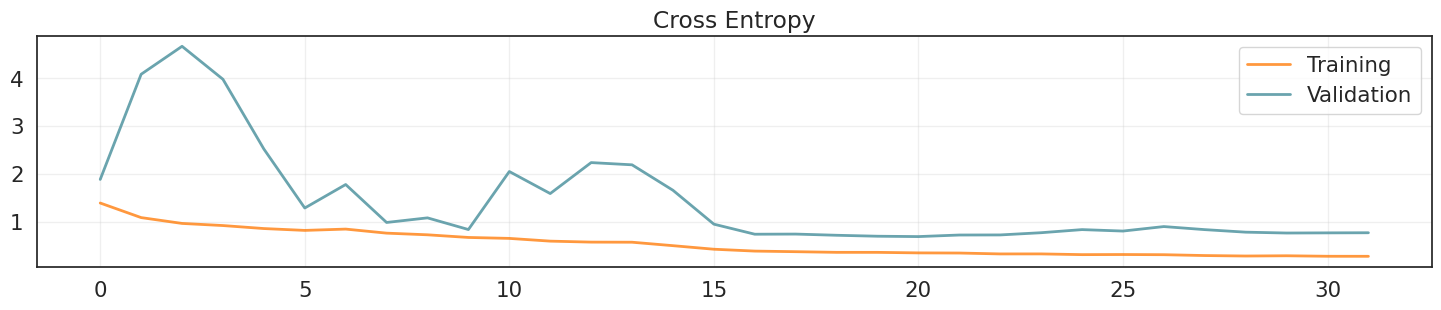

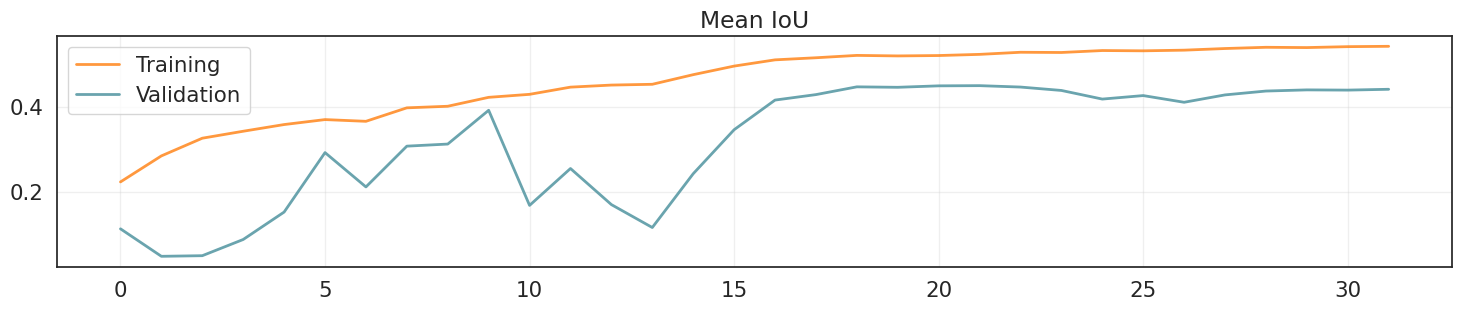

In [ ]:
# Plot and display training and validation loss
plt.figure(figsize=(18, 3))
plt.plot(history['loss'], label='Training', alpha=0.8, color='#ff7f0e', linewidth=2)
plt.plot(history['val_loss'], label='Validation', alpha=0.9, color='#5a9aa5', linewidth=2)
plt.title('Cross Entropy')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# Plotting mean
plt.figure(figsize=(18, 3))
plt.plot(history['meanIoU'], label='Training', alpha=0.8, color='#ff7f0e', linewidth=2)
plt.plot(history['val_meanIoU'], label='Validation', alpha=0.9, color='#5a9aa5', linewidth=2)
plt.title('Mean IoU')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

In [ ]:
from datetime import datetime

current_time = datetime.now().strftime("%d|%m-%H:%M")

model_filename = f'UNet3+_{current_time}.keras'
print("Saved as :",model_filename)

# Storing the model, while ignoring the optimizer
model.save(f'models/{model_filename}', include_optimizer=False)

Saved as : UNet3+_11|12-13:52.keras


In [ ]:
num_classes = NUM_CLASSES
classes = {
    0: "Background",
    1: "Soil",
    2: "Bedrock",
    3: "Sand",
    4: "Big Rock"
}

# Creating a colormap
colormap = plt.cm.viridis(np.linspace(0, 1, num_classes))


In [ ]:
import matplotlib.patches as mpatches
# Create legend elements (squares with colors)
legend_elements = []
for i in range(num_classes):
    color = colormap[i]
    patch = mpatches.Patch(color=color, label=f'{classes[i]}')  # Create a square patch
    legend_elements.append(patch)

In [ ]:
# Plotting images util
def plot(images, labels, num_samples=3):
    """
    Display some image and label pairs from the dataset.
    """
    rand_idx = random.sample(range(0,len(images)),num_samples)
    plt.figure(figsize=(20, 8*num_samples))

    for i in range(num_samples):
        image = images[rand_idx[i]]
        image = image.reshape(INPUT_SHAPE)
        label = labels[rand_idx[i]]
        prediction = model.predict(np.expand_dims(image, axis=0))
        prediction = np.argmax(prediction, axis=-1)
        label_np = np.array(label)

        # Plot original image
        plt.subplot(num_samples, 3, i*3 + 1)
        plt.imshow(image,cmap='gray')
        plt.title(f'Image {rand_idx[i]}')
        plt.axis('off')

        # Plot colored label
        plt.subplot(num_samples, 3, i*3 + 2)
        colored_label = colormap[label_np.astype(int)]
        plt.imshow(colored_label)
        plt.title(f'Label {rand_idx[i]}')
        plt.axis('off')
        #plt.legend(handles=legend_elements, loc='upper right', title='Classes')

        # Plot Predictions
        plt.subplot(num_samples, 3, i*3 + 3)
        colored_prediction = colormap[prediction[0].astype(int)]
        plt.imshow(colored_prediction,cmap='gray')
        plt.title(f'Prediction {rand_idx[i]}')
        plt.axis('off')
        #plt.legend(handles=legend_elements, loc='upper right', title='Classes')

    plt.figlegend(handles=legend_elements, loc='upper right', title='Classes')

    plt.tight_layout()
    plt.show()
    plt.close()

1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


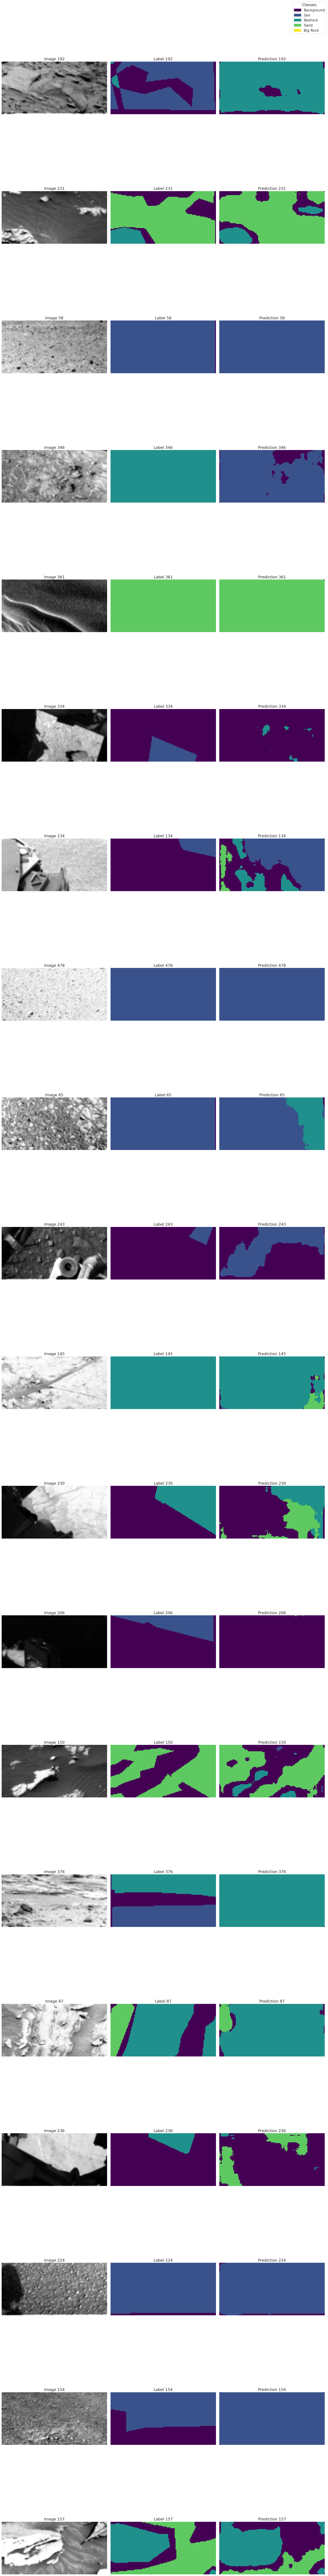

In [ ]:
argmaxed_y_val = np.argmax(y_val, axis=-1)
plot(X_val, argmaxed_y_val, num_samples=20)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


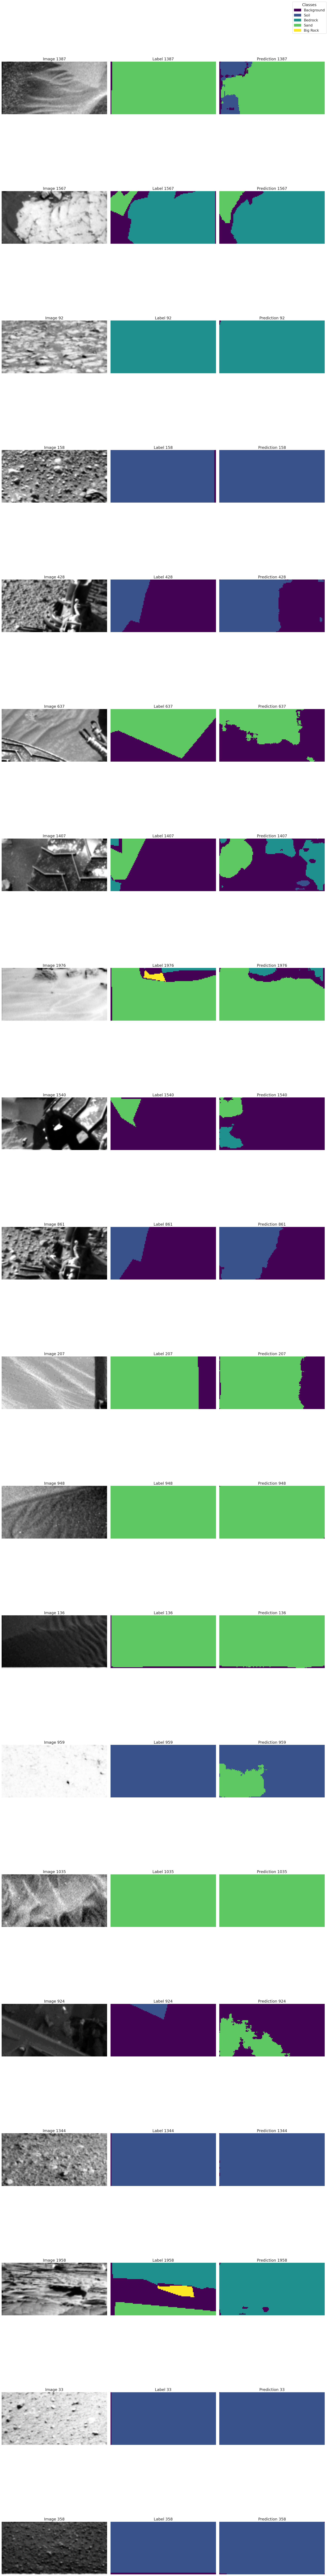

In [ ]:
argmaxed_y_train = np.argmax(y_train, axis=-1)
plot(X_train,argmaxed_y_train,num_samples=20)

## Test Prediction and Final Evaluation

In [ ]:
# Predict class probabilities and get predicted classes
test_predictions = model.predict(test_img_local, verbose=0)[2]
test_predictions = np.argmax(test_predictions, axis=-1)
test_lbl_local = np.argmax(test_lbl_local, axis=-1)

In [ ]:
print(f"Predictions shape: {test_predictions.shape}")
print(f"Labels shape: {test_lbl_local.shape}")

Predictions shape: (500, 64, 128)
Labels shape: (500, 64, 128)


In [ ]:
# Calculate and display test set accuracy
test_accuracy = accuracy_score(test_lbl_local.flatten(), test_predictions.flatten())
print(f'Accuracy score over the test set: {round(test_accuracy, 4)}')

# Calculate and display test set precision
test_precision = precision_score(test_lbl_local.flatten(), test_predictions.flatten(), average='weighted', zero_division=0)
print(f'Precision score over the test set: {round(test_precision, 4)}')

# Calculate and display test set recall
test_recall = recall_score(test_lbl_local.flatten(), test_predictions.flatten(), average='weighted')
print(f'Recall score over the test set: {round(test_recall, 4)}')

# Calculate and display test set F1 score
test_f1 = f1_score(test_lbl_local.flatten(), test_predictions.flatten(), average='weighted')
print(f'F1 score over the test set: {round(test_f1, 4)}')

# Calculate and display test set mean Intersection Over Union score
test_miou = MeanIoU(NUM_CLASSES)
test_miou.update_state(test_lbl_local, test_predictions)
test_miou = test_miou.result().numpy()
print(f'Mean Intersection over Union over the test set: {round(test_miou, 4)}')

Accuracy score over the test set: 0.6939
Precision score over the test set: 0.6859
Recall score over the test set: 0.6939
F1 score over the test set: 0.6837
Mean Intersection over Union over the test set: 0.42080000042915344


## Submission

In [ ]:
print(X_test.shape)
X_test_reshape = X_test.reshape(-1, 64, 128, 1)
preds = model.predict(X_test_reshape)
preds = np.argmax(preds, axis=-1)
print(f"Predictions shape: {preds.shape}")

(10022, 64, 128)
314/314 ━━━━━━━━━━━━━━━━━━━━ 21s 30ms/step
Predictions shape: (10022, 64, 128)


In [ ]:
def y_to_df(y) -> pd.DataFrame:
    """Converts segmentation predictions into a DataFrame format for Kaggle."""
    n_samples = len(y)
    y_flat = y.reshape(n_samples, -1)
    df = pd.DataFrame(y_flat)
    df["id"] = np.arange(n_samples)
    cols = ["id"] + [col for col in df.columns if col != "id"]
    return df[cols]

In [ ]:
# Create and download the csv submission file
model_filename = 'UNet3+'
timestep_str = model_filename.replace("model_", "").replace(".keras", "")
submission_filename = f"submissions/submission_{timestep_str}.csv"
submission_df = y_to_df(preds)
submission_df.to_csv(submission_filename, index=False)